In [1]:
import pandas as pd
from pandas_analysis import calculate_anomalies, plot_confusion_matrices_separately
from methods_from_spark import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv('data/finnhub_anomalies1.csv')
columns = ['symbol', 'trade_ts', 'price', 'volume', 'price_anomaly', 'volume_anomaly']
df = df[columns]
df = df.head(4000)
df["price_pred"] = df["price_anomaly"]
df["volume_pred"] = df["volume_anomaly"]
df = df.drop(columns=['price_anomaly', 'volume_anomaly'])
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df["trade_ts"] = pd.to_datetime(df["trade_ts"], format=timestamp_format, errors='coerce')


In [3]:
# z_df = calculate_anomalies(15, df, z_score_anomalies, iforest=False)
# iqr_df = calculate_anomalies(15, df, iqr_anomalies, iforest=False)
# arima_df = calculate_anomalies(15, df, arima_anomalies, iforest=False)
# iforest_df = calculate_anomalies(15, df, iforest_anomalies, iforest=False)

In [4]:
batched_df = calculate_anomalies(15, df, iforest_anomalies, iforest=True)

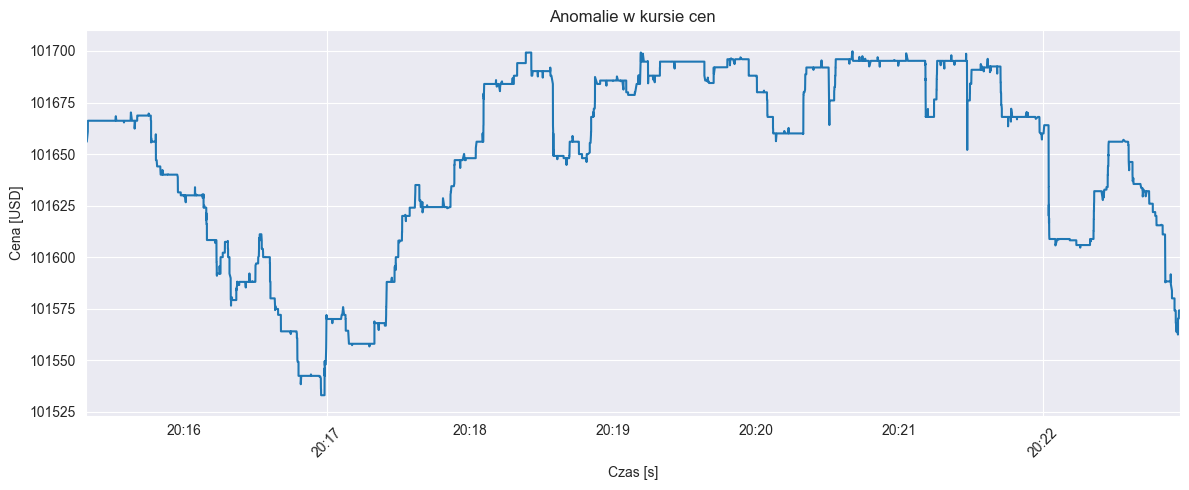

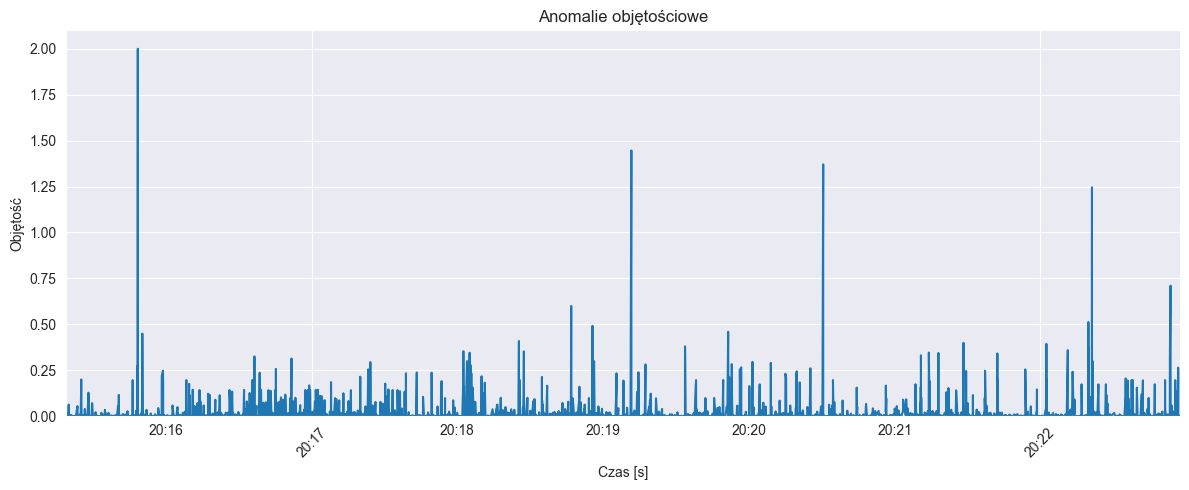

In [5]:
# Define y-axis limits for price
y_min_price = batched_df["price"].min() * 0.9999
y_max_price = batched_df["price"].max() * 1.0001

# Define y-axis limits for volume
y_min_volume = 0
y_max_volume = batched_df["volume"].max() * 1.05

# Create first figure for Price anomalies
fig_price, ax_price = plt.subplots(figsize=(12, 5))

anomalies_price = batched_df[batched_df['price_pred'] == 1]
pandas_price = batched_df[batched_df['predicted_prices'] == 1]

ax_price.plot(batched_df["trade_ts"], batched_df["price"], label="Kurs cen")
# ax_price.scatter(anomalies_price["trade_ts"], anomalies_price["price"], color='red', label="True", zorder=5)
# ax_price.scatter(pandas_price["trade_ts"], pandas_price["price"], color='green', label="Pred", zorder=5, alpha=0.5)
ax_price.set_title("Anomalie w kursie cen")
ax_price.set_xlabel("Czas [s]")
ax_price.set_ylabel("Cena [USD]")
ax_price.set_xlim(batched_df["trade_ts"].min(), batched_df["trade_ts"].max())
ax_price.set_ylim(y_min_price, y_max_price)
ax_price.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax_price.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_price.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
ax_price.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax_price.tick_params(axis='x', rotation=45)
ax_price.grid(True)
plt.tight_layout()

# Create second figure for Volume anomalies
fig_volume, ax_volume = plt.subplots(figsize=(12, 5))

anomalies_volume = batched_df[batched_df['volume_pred'] == 1]
pandas_volume = batched_df[batched_df['predicted_volumes'] == 1]

ax_volume.plot(batched_df["trade_ts"], batched_df["volume"], label="Wolumen")
# ax_volume.scatter(anomalies_volume["trade_ts"], anomalies_volume["volume"], color='red', label="True", zorder=5)
# ax_volume.scatter(pandas_volume["trade_ts"], pandas_volume["volume"], color='green', label="Pred", zorder=5, alpha=0.5)
ax_volume.set_title("Anomalie objętościowe")
ax_volume.set_xlabel("Czas [s]")
ax_volume.set_ylabel("Objętość")
ax_volume.set_xlim(batched_df["trade_ts"].min(), batched_df["trade_ts"].max())
ax_volume.set_ylim(y_min_volume, y_max_volume)
ax_volume.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax_volume.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_volume.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
ax_volume.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax_volume.tick_params(axis='x', rotation=45)
ax_volume.grid(True)
plt.tight_layout()

# Show the figures
plt.show()


<Axes: >

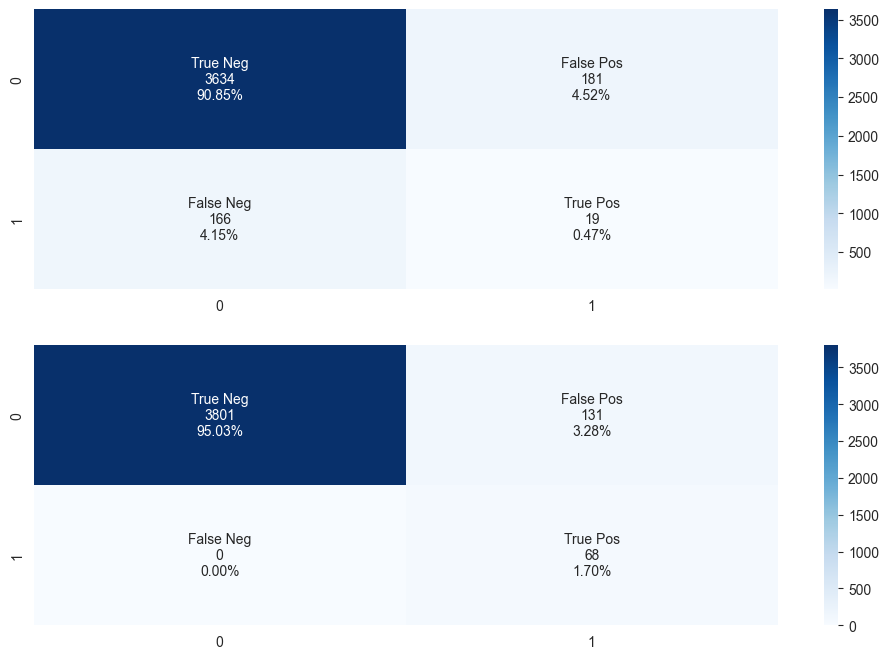

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
y_true_prices = batched_df["price_pred"]  # predicted in spark / from make anomalies
y_pred_prices = batched_df["predicted_prices"].astype(int)  # predicted in pandas
y_true_volumes = batched_df["volume_pred"]  # predicted in spark / from make anomalies
y_pred_volumes = batched_df["predicted_volumes"].astype(int)  # predicted in pandas
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
conf_matrix_prices = confusion_matrix(y_true_prices, y_pred_prices)
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix_prices.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix_prices.flatten() / np.sum(conf_matrix_prices)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix_prices, annot=labels, fmt='', cmap="Blues", ax=ax[0])
conf_matrix_volumes = confusion_matrix(y_true_volumes, y_pred_volumes)
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix_volumes.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix_volumes.flatten() / np.sum(conf_matrix_volumes)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix_volumes, annot=labels, fmt='', cmap="Blues", ax=ax[1])

Number of batches: 267, batch size: 15
Number of batches: 267, batch size: 15


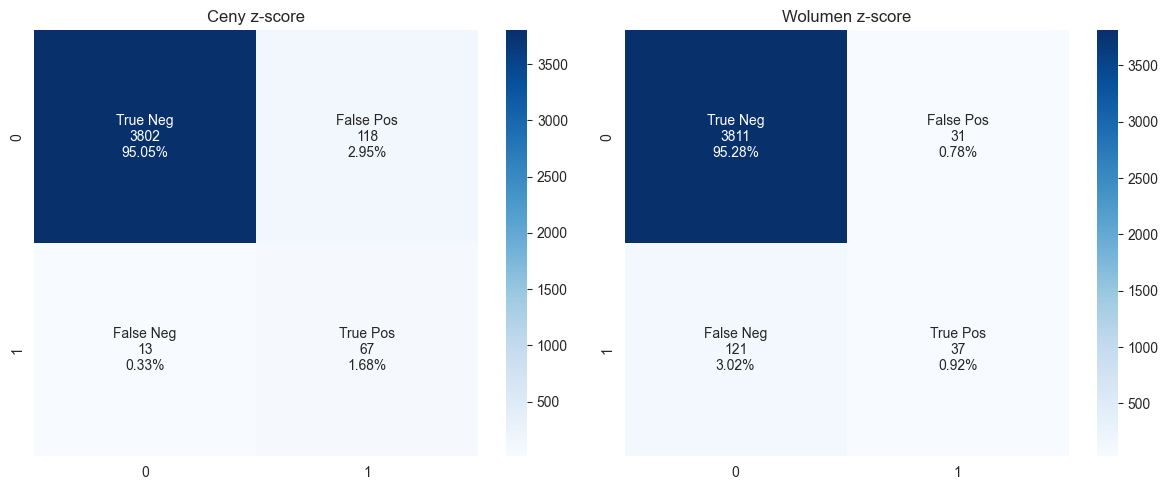

Number of batches: 267, batch size: 15
Number of batches: 267, batch size: 15


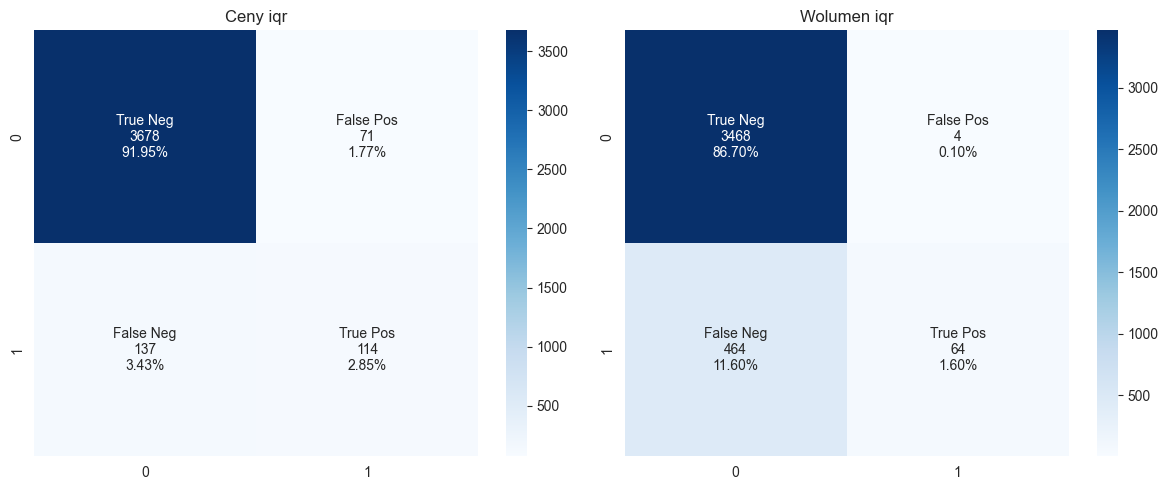

Number of batches: 267, batch size: 15


In [ ]:
titles = ["z-score", "iqr", "arima", "iforest"]
plot_confusion_matrices_separately(df, df, df, df, titles=titles, raw=True)